In [1]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
from torch.utils.data import Dataset, DataLoader
from dataset import fMRI_Dataset, fMRI_Text_Dataset, fMRI_Augmentation_Dataset
import torch
from torch import nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger
from network import Encoder, ContrastiveModel
import torch
import torch.nn as nn
import pytorch_lightning as pl

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()
wandb.init(project="BrainTuning",config={"model":"best_text_model", "augmentations":True})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


In [3]:
## load the data

train_datasets=[]
val_datasets=[]
test_datasets=[]

aumentation_N = 500


for subj in tqdm.tqdm(["CSI1","CSI2","CSI3","CSI4"]):

    subj_id = int(subj.split("CSI")[1])

    data_path =  f"/home/matteo/storage/brain_tuning/{subj}"

    train_fmri = np.load(opj(data_path, "TEXT_train_fmri_top.npy"))
    val_fmri = np.load(opj(data_path, "TEXT_val_fmri_top.npy"))
    test_fmri = np.load(opj(data_path, "TEXT_test_fmri_top.npy"))

    ##load the captions
    train_captions = np.load(opj(data_path, "train_captions.npy"),allow_pickle=True)
    val_captions = np.load(opj(data_path, "val_captions.npy"),allow_pickle=True)
    test_captions = np.load(opj(data_path, "test_captions.npy"),allow_pickle=True)

    ## load the features
    train_features = np.load(opj(data_path, "train_text_features.npy"))
    val_features = np.load(opj(data_path, "val_text_features.npy"))
    test_features = np.load(opj(data_path, "test_text_features.npy"))

    print("Using augmentations")
    ## load the augmentations
    train_augmentations = np.load(opj(data_path, "TEXT_augmented_brain.npy"))[:aumentation_N]
    
    # add a small noise to the augmentations
    train_augmentations = train_augmentations + np.random.normal(0,0.8,train_augmentations.shape)

    ## force the augmentations to have the same mean and std as the original fmri
    train_augmentations = train_augmentations - train_augmentations.mean(0)
    train_augmentations = train_augmentations/train_augmentations.std(0)
    train_augmentations = train_augmentations*train_fmri.std(0)
    train_augmentations = train_augmentations + train_fmri.mean(0)
     #set dtype to float32
    train_augmentations = train_augmentations.astype(np.float32)

    #load the augmented features
    train_augmented_features = np.load("/home/matteo/storage/brain_tuning/clean_augment_text_features.npy")[:aumentation_N]

    #concatenate the augmented and the original features
    train_fmri = np.concatenate([train_augmentations,train_fmri])
    train_features = np.concatenate([train_augmented_features,train_features])

    ## create the dataset
    train_dataset = fMRI_Augmentation_Dataset(train_fmri,train_features,subj_id) #no imags here, just features

    ## create the dataset
    val_dataset = fMRI_Text_Dataset(val_fmri,val_captions,val_features,subj_id)
    test_dataset = fMRI_Text_Dataset(test_fmri,test_captions,test_features,subj_id)

    ## append the datasets
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)





  0%|          | 0/4 [00:00<?, ?it/s]

Using augmentations


 25%|██▌       | 1/4 [00:20<01:02, 20.77s/it]

Using augmentations


 50%|█████     | 2/4 [00:24<00:21, 10.90s/it]

Using augmentations


 75%|███████▌  | 3/4 [00:26<00:06,  6.77s/it]

Using augmentations


100%|██████████| 4/4 [00:28<00:00,  7.05s/it]


In [4]:
## Concatenate the datasets
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)


In [5]:
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
## optimal parameter obtained from the hyperparameter search

act_fn = nn.Identity
base_channel_size = [2048]
hidden_dims = [1024]
latent_dim = 512

loss_type = "contrastive"
lr = 1e-4
temperature = 0.1
wd = 1e-5
alpha = 0.8

In [7]:
brain_model = ContrastiveModel(num_input_channels= 10000,
                                base_channel_size=base_channel_size, 
                                hidden_dims=hidden_dims,
                                latent_dim=latent_dim,
                                act_fn=act_fn,
                                loss_type=loss_type,
                                lr = lr,
                                wd = wd,
                                alpha=alpha)

# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Create a unique checkpoint directory based on the run name or ID
run_name = wandb.run.name or wandb.run.id  # Use run name if available, otherwise use run ID
checkpoint_dir = os.path.join(data_path, "models_augmented", run_name)
os.makedirs(checkpoint_dir, exist_ok=True)

# Model checkpoint configuration
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath=checkpoint_dir,filename='TEXT_brain_model_AUGMENTED-{epoch:02d}-{val_loss:.2f}',save_top_k=3,mode='min',)


# Initialize trainer with logger

trainer = pl.Trainer(max_epochs=20, devices=[1], callbacks=[early_stop_callback,checkpoint_callback],logger=wandb_logger ) # Add the wandb logger here

trainer.fit(brain_model, train_loader, val_loader)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteo/anaconda3/envs/borg/lib/python3.8/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, re

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 31/31 [00:00<00:00, 36.64it/s, v_num=ndgb, train_loss_step=4.910, val_loss=5.450, val_mse_loss=1.780, val_cosine_similarity=0.126, train_loss_epoch=5.800]

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 359. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 5.451


Epoch 1: 100%|██████████| 31/31 [00:00<00:00, 42.27it/s, v_num=ndgb, train_loss_step=4.300, val_loss=5.240, val_mse_loss=1.720, val_cosine_similarity=0.154, train_loss_epoch=4.960]

Metric val_loss improved by 0.207 >= min_delta = 0.0. New best score: 5.243


Epoch 2: 100%|██████████| 31/31 [00:00<00:00, 40.79it/s, v_num=ndgb, train_loss_step=3.890, val_loss=5.140, val_mse_loss=1.690, val_cosine_similarity=0.166, train_loss_epoch=4.500]

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 5.138


Epoch 3: 100%|██████████| 31/31 [00:00<00:00, 41.27it/s, v_num=ndgb, train_loss_step=3.510, val_loss=5.080, val_mse_loss=1.680, val_cosine_similarity=0.172, train_loss_epoch=4.130]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 5.083


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 41.07it/s, v_num=ndgb, train_loss_step=3.270, val_loss=5.060, val_mse_loss=1.680, val_cosine_similarity=0.173, train_loss_epoch=3.830]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 5.059


Epoch 5: 100%|██████████| 31/31 [00:00<00:00, 41.68it/s, v_num=ndgb, train_loss_step=2.960, val_loss=5.050, val_mse_loss=1.680, val_cosine_similarity=0.174, train_loss_epoch=3.580]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 5.045


Epoch 6: 100%|██████████| 31/31 [00:00<00:00, 40.98it/s, v_num=ndgb, train_loss_step=2.830, val_loss=5.050, val_mse_loss=1.680, val_cosine_similarity=0.172, train_loss_epoch=3.380]

Monitored metric val_loss did not improve in the last 1 records. Best score: 5.045. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 31/31 [00:01<00:00, 27.11it/s, v_num=ndgb, train_loss_step=2.830, val_loss=5.050, val_mse_loss=1.680, val_cosine_similarity=0.172, train_loss_epoch=3.380]


In [8]:
# train_features.shape

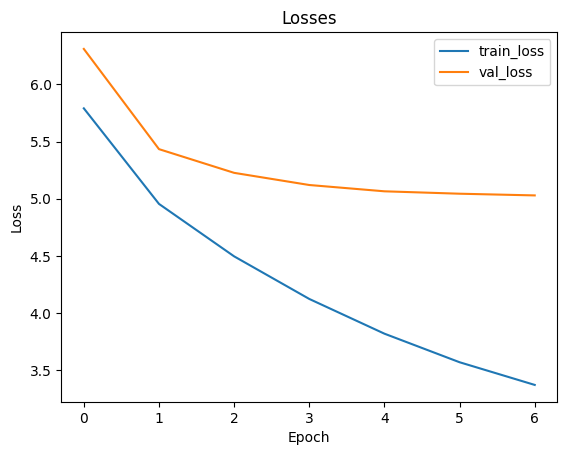

<Figure size 640x480 with 0 Axes>

In [9]:
## plot the losses
output_path = "/home/matteo/storage/brain_tuning/"

plt.plot(brain_model.train_history['train_loss'], label='train_loss')
plt.plot(brain_model.val_history['val_loss'][:-1], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.show()

## save the plot
plt.savefig(opj(output_path, "text_losses_augmented.png"))

In [10]:
from text_evaluation import *


In [11]:
results_df, similarity_matrices, results = evaluate_and_log(test_loader,brain_model)


100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


Starting evaluation...
Evaluating metrics for subject 1...
Computed similarity matrix for subject 1.
Top-1 Accuracy: 0.0215, Top-5 Accuracy: 0.0900 for subject 1.
Identification accuracy for subject 1: 0.8491
Logged top-5 retrievals for subject 1.
Evaluating metrics for subject 2...
Computed similarity matrix for subject 2.
Top-1 Accuracy: 0.0152, Top-5 Accuracy: 0.0646 for subject 2.
Identification accuracy for subject 2: 0.8161
Logged top-5 retrievals for subject 2.
Evaluating metrics for subject 3...
Computed similarity matrix for subject 3.
Top-1 Accuracy: 0.0266, Top-5 Accuracy: 0.0697 for subject 3.
Identification accuracy for subject 3: 0.8133
Logged top-5 retrievals for subject 3.
Evaluating metrics for subject 4...
Computed similarity matrix for subject 4.
Top-1 Accuracy: 0.0171, Top-5 Accuracy: 0.0664 for subject 4.
Identification accuracy for subject 4: 0.7759
Logged top-5 retrievals for subject 4.
Evaluation complete. Results loaded to wandb.


In [12]:
results_df

,Subject,Identification Accuracy (%),ID Accuracy Baseline (%),Top-1 Accuracy (%),Top1 Baseline (%),Top1 Improvement Over Baseline,Top-5 Accuracy (%),Top5 Baseline (%),Top5 Improvement Over Baseline
0,1,84.905876,50,2.154626,0.126743,17.0,8.998733,0.633714,14.2
1,2,81.605579,50,1.520913,0.126743,12.0,6.463878,0.633714,10.2
2,3,81.325555,50,2.661597,0.126743,21.0,6.970849,0.633714,11.0
3,4,77.591879,50,1.713062,0.214133,8.0,6.638116,1.070664,6.2


In [14]:
results_df.to_csv(opj(output_path,"results_text_augmented_contrastive.csv"))